In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.widgets import Button, CheckButtons
from ipywidgets import Output
import time
import copy
import math
plt.style.use('./deeplearning.mplstyle')
np.set_printoptions(precision=2)

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]
plt.style.use('./deeplearning.mplstyle')

In [17]:
def draw_vthresh(ax,x):
    """ draws a threshold """
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.fill_between([xlim[0], x], [ylim[1], ylim[1]], alpha=0.2, color=dlblue)
    ax.fill_between([x, xlim[1]], [ylim[1], ylim[1]], alpha=0.2, color=dldarkred)
    ax.annotate("z >= 0", xy= [x,0.5], xycoords='data',
                xytext=[30,5],textcoords='offset points')
    d = FancyArrowPatch(
        posA=(x, 0.5), posB=(x+3, 0.5), color=dldarkred,
        arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
    )
    ax.add_artist(d)
    ax.annotate("z < 0", xy= [x,0.5], xycoords='data',
                 xytext=[-50,5],textcoords='offset points', ha='left')
    f = FancyArrowPatch(
        posA=(x, 0.5), posB=(x-3, 0.5), color=dlblue,
        arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
    )
    ax.add_artist(f)

def compute_gradient_matrix(X, y, w, b, logistic=False, lambda_=0):
    """
    Computes the gradient using matrices

    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameters of the model
      b : (scalar )                       Values of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
    Returns
      dj_dw: (array_like Shape (n,1))     The gradient of the cost w.r.t. the parameters w
      dj_db: (scalar)                     The gradient of the cost w.r.t. the parameter b
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D

    f_wb  = sigmoid( X @ w + b ) if logistic else  X @ w + b      # (m,n)(n,1) = (m,1)
    err   = f_wb - y                                              # (m,1)
    dj_dw = (1/m) * (X.T @ err)                                   # (n,m)(m,1) = (n,1)
    dj_db = (1/m) * np.sum(err)                                   # scalar

    dj_dw += (lambda_/m) * w        # regularize                  # (n,1)

    return dj_db, dj_dw     

def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1+np.exp(-z))
    return g

def log_1pexp(x, maximum=20):
    ''' approximate log(1+exp^x)
        https://stats.stackexchange.com/questions/475589/numerical-computation-of-cross-entropy-in-practice
    Args:
    x   : (ndarray Shape (n,1) or (n,)  input
    out : (ndarray Shape matches x      output ~= np.log(1+exp(x))
    '''

    out  = np.zeros_like(x,dtype=float)
    i    = x <= maximum
    ni   = np.logical_not(i)

    out[i]  = np.log(1 + np.exp(x[i]))
    out[ni] = x[ni]
    return out

def compute_cost_matrix(X, y, w, b, logistic=False, lambda_=0, safe=True):
    """
    Computes the cost using  using matrices
    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameter(s) of the model
      b : (scalar )                       Values of parameter of the model
      verbose : (Boolean) If true, print out intermediate value f_wb
    Returns:
      total_cost: (scalar)                cost
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D
    if logistic:
        if safe:  #safe from overflow
            z = X @ w + b                                                           #(m,n)(n,1)=(m,1)
            cost = -(y * z) + log_1pexp(z)
            cost = np.sum(cost)/m                                                   # (scalar)
        else:
            f    = sigmoid(X @ w + b)                                               # (m,n)(n,1) = (m,1)
            cost = (1/m)*(np.dot(-y.T, np.log(f)) - np.dot((1-y).T, np.log(1-f)))   # (1,m)(m,1) = (1,1)
            cost = cost[0,0]                                                        # scalar
    else:
        f    = X @ w + b                                                        # (m,n)(n,1) = (m,1)
        cost = (1/(2*m)) * np.sum((f - y)**2)                                   # scalar

    reg_cost = (lambda_/(2*m)) * np.sum(w**2)                                   # scalar

    total_cost = cost + reg_cost                                                # scalar

    return total_cost 

def gradient_descent(X, y, w_in, b_in, alpha, num_iters, logistic=False, lambda_=0, verbose=True):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray):    Shape (m,n)         matrix of examples
      y (ndarray):    Shape (m,) or (m,1) target value of each example
      w_in (ndarray): Shape (n,) or (n,1) Initial values of parameters of the model
      b_in (scalar):                      Initial value of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
      alpha (float):                      Learning rate
      num_iters (int):                    number of iterations to run gradient descent

    Returns:
      w (ndarray): Shape (n,) or (n,1)    Updated values of parameters; matches incoming shape
      b (scalar):                         Updated value of parameter
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    w = w.reshape(-1,1)      #prep for matrix operations
    y = y.reshape(-1,1)

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient_matrix(X, y, w, b, logistic, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost_matrix(X, y, w, b, logistic, lambda_) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            if verbose: print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")

    return w.reshape(w_in.shape), b, J_history  #return final w,b and J history for graphing

In [10]:
# Input is an array. 
input_array = np.array([1,2,3])
exp_array = np.exp(input_array)

print("Input to exp:", input_array)
print("Output of exp:", exp_array)

# Input is a single number
input_val = 1  
exp_val = np.exp(input_val)

print("Input to exp:", input_val)
print("Output of exp:", exp_val)

Input to exp: [1 2 3]
Output of exp: [ 2.72  7.39 20.09]
Input to exp: 1
Output of exp: 2.718281828459045


In [19]:
# Generate an array of evenly spaced values between -10 and 10
z_tmp = np.arange(-10,11)

# Use the function implemented above to get the sigmoid values
y = sigmoid(z_tmp)

# Code for pretty printing the two arrays next to each other
np.set_printoptions(precision=3) 
print("Input (z), Output (sigmoid(z))")
print(np.c_[z_tmp, y])

Input (z), Output (sigmoid(z))
[[-1.000e+01  4.540e-05]
 [-9.000e+00  1.234e-04]
 [-8.000e+00  3.354e-04]
 [-7.000e+00  9.111e-04]
 [-6.000e+00  2.473e-03]
 [-5.000e+00  6.693e-03]
 [-4.000e+00  1.799e-02]
 [-3.000e+00  4.743e-02]
 [-2.000e+00  1.192e-01]
 [-1.000e+00  2.689e-01]
 [ 0.000e+00  5.000e-01]
 [ 1.000e+00  7.311e-01]
 [ 2.000e+00  8.808e-01]
 [ 3.000e+00  9.526e-01]
 [ 4.000e+00  9.820e-01]
 [ 5.000e+00  9.933e-01]
 [ 6.000e+00  9.975e-01]
 [ 7.000e+00  9.991e-01]
 [ 8.000e+00  9.997e-01]
 [ 9.000e+00  9.999e-01]
 [ 1.000e+01  1.000e+00]]


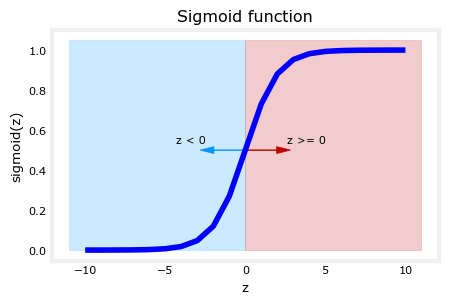

In [20]:
# Plot z vs sigmoid(z)
fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(z_tmp, y, c="b")

ax.set_title("Sigmoid function")
ax.set_ylabel('sigmoid(z)')
ax.set_xlabel('z')
draw_vthresh(ax,0)

In [21]:
x_train = np.array([0., 1, 2, 3, 4, 5])
y_train = np.array([0,  0, 0, 1, 1, 1])

w_in = np.zeros((1))
b_in = 0